#Final project

#Introduction

In this project a Neural Network has been trained with different images of cats and dogs so it can predict if the image is of a dog or cat.
This Data contains in total 25000 images of cats and dogs. The Data has 20000 images for training and 5000 for test.

The 2 classes are: 'cat', 'dog'



#Dependencies

In [ ]:
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from google.colab import drive
from os import sep

from sklearn.metrics import confusion_matrix
import itertools

import plotly.express as px

from scipy import ndimage
import scipy as sp
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator



#General functions

Function for showing random images.

In [ ]:
class_names = ['cat', 'dog']
def plot_data(dataset, n_images):
    i = 1
    images, labels = dataset.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

#Presents

In [ ]:
PROJECT_NAME = 'catsdogs'

PROJECT_ROUTE = 'drive' + sep + 'MyDrive' + sep + 'PAIA 1' + sep + 'Projects' + sep + PROJECT_NAME + sep

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
%cd $PROJECT_ROUTE

/content/drive/.shortcut-targets-by-id/1iqzmXhMTFAsMpUXWZS4a8r3N4tkeW2wy/PAIA 1/Projects/catsdogs


# Data preparation

Show all folders in root project directory (in this dataset, num folders = num classes)

In [ ]:
%ls -l

total 4484
drwx------ 2 root root    4096 May 30 20:03  cat/
-rw------- 1 root root 4582803 Jun 16 03:13 'Cat Dogs Project.ipynb'
drwx------ 2 root root    4096 May 30 20:03  dog/


Show file count of each folder in root project directory (in this dataset, files in each folder = examples in each class) so we can see how the data is distrubuted.

In [ ]:
!du -a | cut -d/ -f2 | sort | uniq -c | sort -nr

  12501 dog
  12501 cat
      1 Cat Dogs Project.ipynb
      1 839692	.


In [ ]:
n_dogs = len(os.listdir('dog'))
n_cats = len(os.listdir('cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

The data is perfectly split between the two classes which means that there is no majority class to skew the model.

## Load Dataset

First we make the directories for the images.

In [ ]:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')

Now we make the function to split the data

In [ ]:
def split_data(main_dir, training_dir, validation_dir,  split_size=0.8):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)):
            files.append(file)

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(split_size * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:] #validation split

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))

    print("Split sucessful!")

In [ ]:
split_data('cat', '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats')
split_data('dog', '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs')

Split sucessful!
Split sucessful!


Let's check if the data is split properly

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

9999
9999
2500
2500


Now we load the images into datasets.

In our dataset, we have the problem of our images not being the same resolution. Here we define the resolution to which our images will be resized to when they are being loaded.

In [ ]:
img_height = 256
img_width = 256


The values of the batch of images is, by default, in the 0-255 range. By rescaling the values to be 0-1, we can enhance the performance and training efficiency of our model.

In [ ]:
train_ds = ImageDataGenerator(
        rescale=1./255)

test_ds =  ImageDataGenerator(
        rescale=1./255.)

The batch size is a hyperparameter that defines the number of samples (single rows of data) to work through before updating the internal model parameters (those being the weights and biases)

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_ds = train_ds.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        class_mode='binary')
test_ds = test_ds.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


#Data understanding

Let us check if the data is loaded properly.

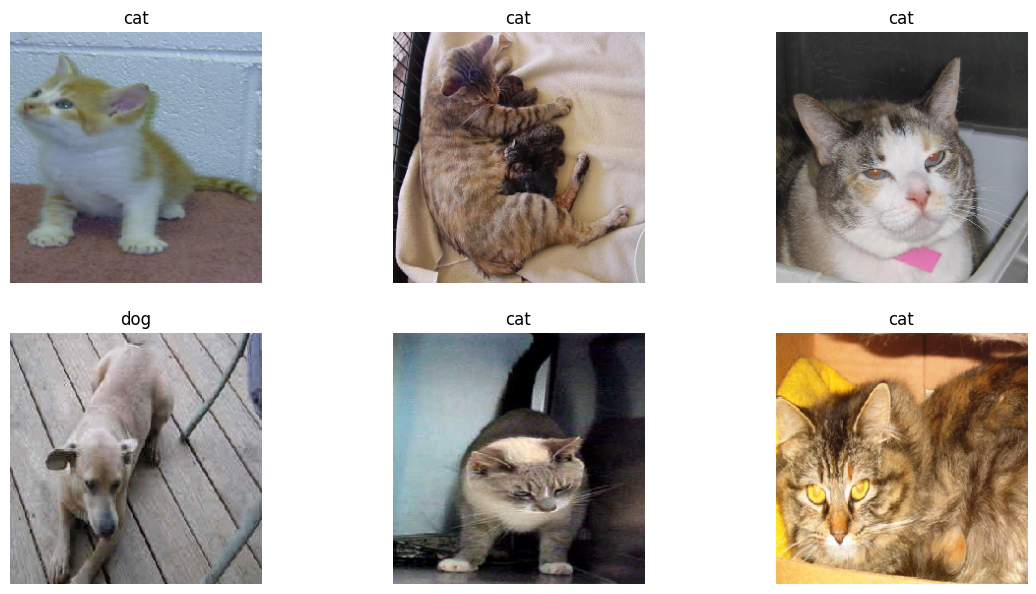

In [ ]:
plot_data(train_ds,7)


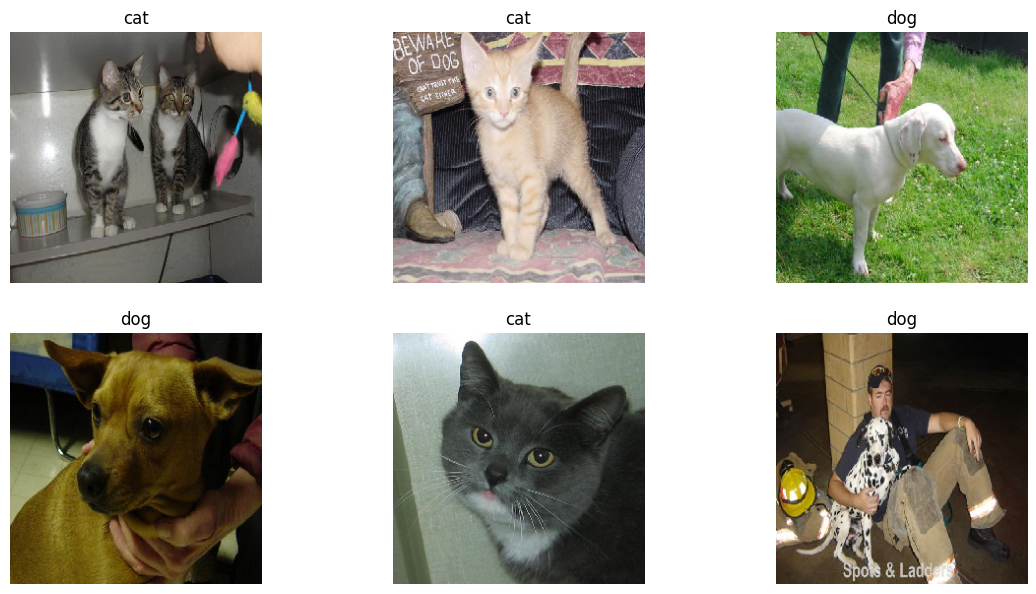

In [ ]:
plot_data(test_ds,7)


Here we see some examples of images in the dataset. We have a few potential problems:

1. The main problem is that there are images with people on them, we can use data augmentation to potentially solve this problem which we will do later on.
2. The other problem is varied image quality and composition. Images in the dataset might have variations in quality, resolution, lighting conditions, backgrounds, and compositions. Such variations can make it challenging for the model to generalize well and may impact its performance. We use preprocessing techniques, such as image resizing and normalization to solve this

#Cropping the center of Images

Cropping the center of the images ensures that the subject of the image, wether it be a cat or a dog, remains in the center of the image.

 This helps with the images that contain people as it potentially crops the people out.

In [ ]:
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

In [ ]:
data_standardization_layer = tf.keras.Sequential([
  tf.keras.layers.CenterCrop(img_height, img_width)
])

#First modeling phase

The first three layers are Conv2D layers, one of which has 64 filters each with a size of 3x3, the second has 128 and the third one with 256. The input shape is the same shape of images that they were resized to during data loading.

After each Conv2D layer we add a MaxPooling2D layer. This layer reduces the spatial dimensions of the input by downsampling the output, so , for example, instead of 224x224 it will be 112x112.

After the convolutional layers, we add a Flatten layer. This layer flattens the multi-dimensional feature maps into a one-dimensional vector, preparing the data for the fully connected layers.

Then we have the main Dense layer with 512 neurons.

Finally, we have the output Dense layer, which has the number of neurons equal to the number of classes we want to predict.

In [ ]:
model = tf.keras.models.Sequential([
    data_standardization_layer,
    tf.keras.layers.Conv2D(64, 3, activation='ReLu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, 3, activation='ReLu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, 3, activation='ReLu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation="ReLu"),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

Next we compile the model. We use adam as the optimizer, which is the most widely used and spare_categorical_crossentropy as the loss function.

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Epochs are a hyperparameter that refers to a single pass through the entire training dataset during the training of a machine learning model.

In [ ]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
601/625 [===========================>..] - ETA: 3s - loss: 0.7244 - accuracy: 0.5861

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning:

Truncated File Read



625/625 [==============================] - 132s 199ms/step - loss: 0.7202 - accuracy: 0.5895 - val_loss: 0.9383 - val_accuracy: 0.5780
Epoch 2/10
625/625 [==============================] - 128s 204ms/step - loss: 0.5596 - accuracy: 0.7158 - val_loss: 0.4787 - val_accuracy: 0.7748
Epoch 3/10
625/625 [==============================] - 140s 225ms/step - loss: 0.4235 - accuracy: 0.8073 - val_loss: 0.4497 - val_accuracy: 0.7950
Epoch 4/10
625/625 [==============================] - 119s 190ms/step - loss: 0.2887 - accuracy: 0.8740 - val_loss: 0.5408 - val_accuracy: 0.7776
Epoch 5/10
625/625 [==============================] - 118s 189ms/step - loss: 0.1234 - accuracy: 0.9524 - val_loss: 0.6825 - val_accuracy: 0.7938
Epoch 6/10
625/625 [==============================] - 122s 194ms/step - loss: 0.0410 - accuracy: 0.9866 - val_loss: 1.0429 - val_accuracy: 0.7840
Epoch 7/10
625/625 [==============================] - 123s 196ms/step - loss: 0.0258 - accuracy: 0.9921 - val_loss: 1.0845 - val_accura

#Model evaluation

###Score the model

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 1.5585
Test Accuracy : 0.7780


Based on the score, we can see that the model is performing poorly compared to the training phase.

Let us plot the Training Accuracy vs Loss to get a better understanding of the model training and to check if the model is overfitting.

Text(0.5, 1.0, 'Training - Accuracy')

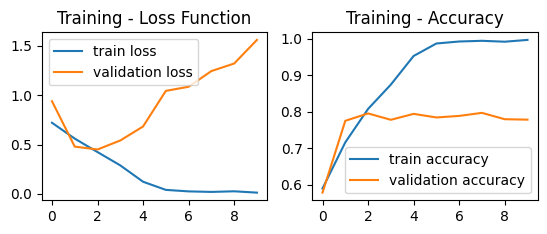

In [ ]:
h = history

# plot the loss value
plt.subplot(2, 2, 1)
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Training - Loss Function')

# plot the accuracy value
plt.subplot(2, 2, 2)
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Training - Accuracy')

The following function shows images and if the model predicted them correctly (blue=correct, red=incorrect)

In [ ]:
def plot_prediction(generator, n_images):
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='b')
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

1/1 [==============================] - 0s 225ms/step


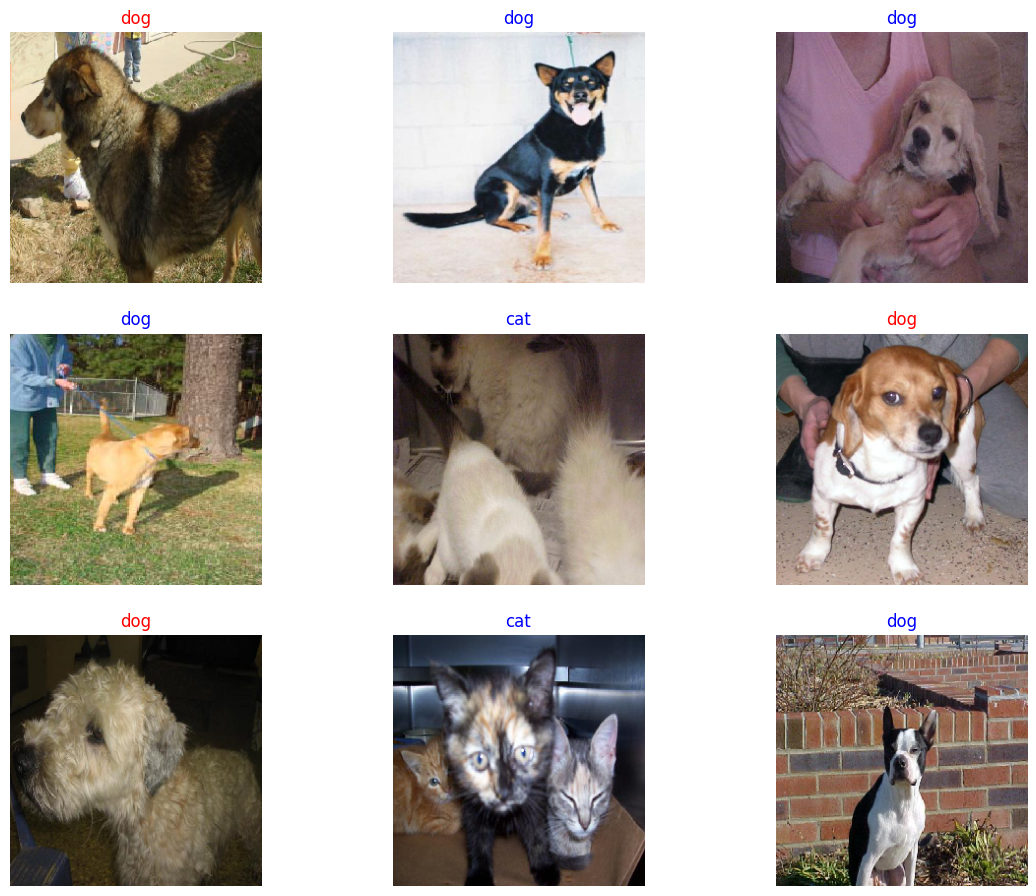

In [ ]:
plot_prediction(test_ds, 10)

##Conclusion of the first modelling phase

Based on the evaluation we can see that our classifier is performing poorly in the validation phase while achieving high accuracy in the training phase.

This means that our model is **overfitting**.

There are several ways to solve overfitting:

- Adding Dropout layers
- Simplifying the model

#Second modelling phase

The second model is more simple compared to the first with less filters in the Conv2D layers.

There are also added Dropout layers with a probability of 25%. This means that 25% of the neuron inputs are going to be 0, which helps with overfitting.

In [ ]:
model = tf.keras.Sequential()
model.add(data_standardization_layer)
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='ReLU', input_shape=input_shape))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='ReLU'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='ReLU'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='ReLU'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 115s 184ms/step - loss: 0.1216 - accuracy: 0.9505 - val_loss: 0.3182 - val_accuracy: 0.8776
Epoch 2/10
625/625 [==============================] - 115s 184ms/step - loss: 0.1238 - accuracy: 0.9505 - val_loss: 0.2411 - val_accuracy: 0.9018
Epoch 3/10
625/625 [==============================] - 116s 185ms/step - loss: 0.1216 - accuracy: 0.9514 - val_loss: 0.2047 - val_accuracy: 0.9174
Epoch 4/10
625/625 [==============================] - 116s 186ms/step - loss: 0.1117 - accuracy: 0.9553 - val_loss: 0.2423 - val_accuracy: 0.9066
Epoch 5/10
625/625 [==============================] - 117s 187ms/step - loss: 0.1064 - accuracy: 0.9576 - val_loss: 0.2658 - val_accuracy: 0.8964
Epoch 6/10
625/625 [==============================] - 116s 185ms/step - loss: 0.1026 - accuracy: 0.9586 - val_loss: 0.2335 - val_accuracy: 0.9102
Epoch 7/10
625/625 [==============================] - 114s 182ms/step - loss: 0.1063 - accuracy: 0.9579 - val_loss: 0.2209 -

#Model evaluation

###Score the model

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2267
Test Accuracy : 0.9130


Let us plot the Training Accuracy vs Loss to get a better understanding of the model training.

In [1]:
h = history

# plot the loss value
plt.subplot(2, 2, 1)
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.ylim(0,1)
plt.legend()
plt.title('Training - Loss Function')

# plot the accuracy value
plt.subplot(2, 2, 2)
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.ylim(0,1)
plt.legend()
plt.title('Training - Accuracy')

NameError: ignored

In [ ]:
def plot_prediction(generator, n_images):
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='b')
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

1/1 [==============================] - 0s 36ms/step


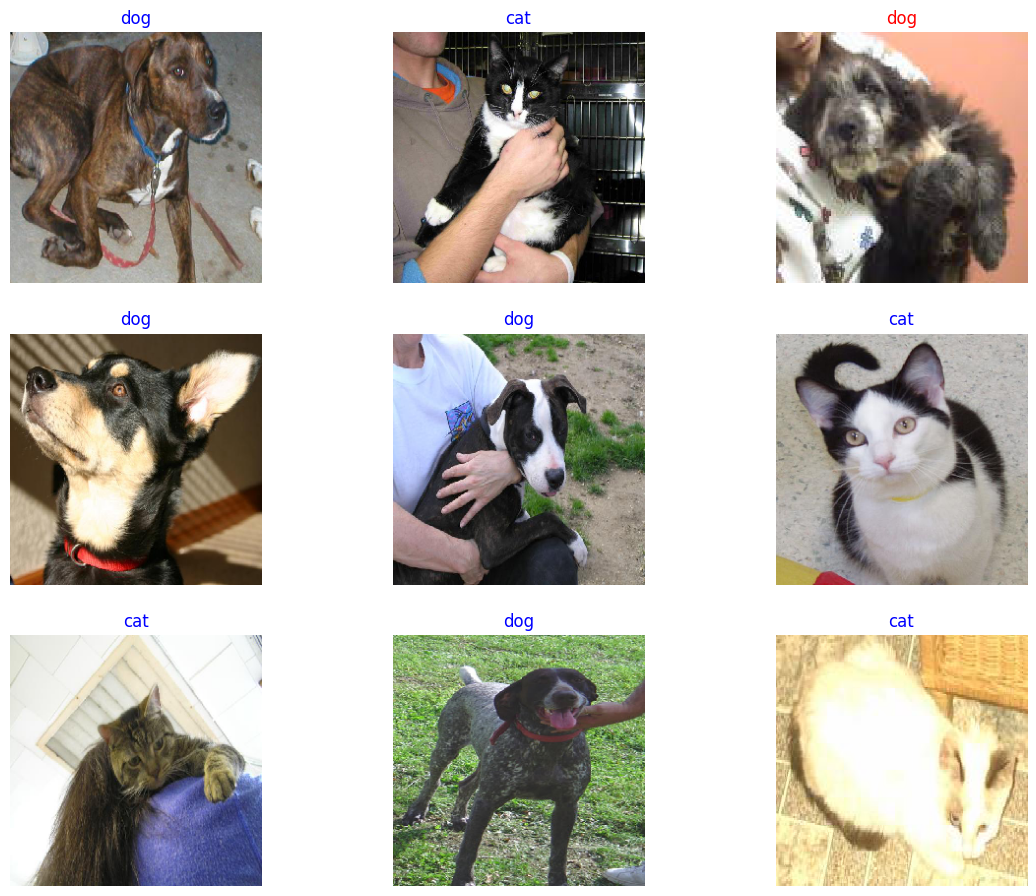

In [ ]:
plot_prediction(test_ds, 10)

###Conclusion of the Second Modelling Phase

We can see that the accuracy has siginificantly improved from 77% to 91%, and that the problem of overfitting has almost been eradicated

Even though the performance of the model has gotten much better, there is still room for improvement.

We can use transfer learning or a more complex architecture to improve the model even more.